# Sparkify - A churn analysis by predicting model

This notebook uses a toy dataset (128MB) made by udacity to analysis churn for a supposed music app called sparkify. The dataset is a log for the events made by the users in the app.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType, DateType, Row, ArrayType
from pyspark.sql.functions import count, when, col, desc, asc, from_unixtime, datediff
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, MinMaxScaler
from pyspark.ml.linalg import DenseVector, SparseVector
from matplotlib import pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime

import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Predicting churn') \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'Predicting churn'),
 ('spark.driver.host', 'c1a755940e3f'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1636068217900'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '41715')]

# Load and Clean Dataset
In this notebook, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [4]:
path = 'mini_sparkify_event_data.json'
user_log = spark.read.json(path)

# Exploratory Data Analysis

### Define Churn

Churn is defined in this case using the event “Cancellation Confirmation”. So let’s create a column to the user's ID and another to say if this user canceled the service of music streaming or not. 

In [5]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
user_log.createOrReplaceTempView('user_log_table')

In [7]:
spark.sql('''
            SELECT * 
            FROM user_log_table
            LIMIT 2
            '''
         ).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9


In [8]:
spark.sql('''
            SELECT userID, auth, level, location, page, song, status
            FROM user_log_table
            WHERE userID = 30
            LIMIT 40
            '''
         ).toPandas()

,userID,auth,level,location,page,song,status
0,30,Logged In,paid,"Bakersfield, CA",NextSong,Rockpools,200
1,30,Logged In,paid,"Bakersfield, CA",NextSong,Time For Miracles,200
2,30,Logged In,paid,"Bakersfield, CA",NextSong,Harder Better Faster Stronger,200
3,30,Logged In,paid,"Bakersfield, CA",NextSong,Passengers (Old Album Version),200
4,30,Logged In,paid,"Bakersfield, CA",Add to Playlist,None,200
5,30,Logged In,paid,"Bakersfield, CA",NextSong,Fuck Kitty,200
6,30,Logged In,paid,"Bakersfield, CA",NextSong,Jade,200
7,30,Logged In,paid,"Bakersfield, CA",NextSong,So-Called Friends,200
8,30,Logged In,paid,"Bakersfield, CA",NextSong,Represent,200
9,30,Logged In,paid,"Bakersfield, CA",NextSong,Here I Am,200


In [9]:
# Displaying all the possible events a user could do
spark.sql('''
            SELECT DISTINCT(page)
            FROM user_log_table
            '''
         ).collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [10]:
is_churn = spark.sql('''
                    SELECT userID, SUM(isChurn) AS isChurn
                    FROM (
                        SELECT userID,
                            CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END AS isChurn
                        FROM user_log_table
                        )
                    GROUP BY 1
                ''')

In [11]:
is_churn.toPandas().head()

,userID,isChurn
0,100010,0
1,200002,0
2,125,1
3,51,1
4,124,0


### Explore Data
Let's do some exploratory data analysis to observe the behavior for users who stayed vs users who churned.

In [12]:
# Total log registers
spark.sql('''
            SELECT COUNT(*) 
            FROM user_log_table
            '''
         ).show()

+--------+
|count(1)|
+--------+
|  286500|
+--------+



In [13]:
# Total of unique users
spark.sql('''
            SELECT COUNT(DISTINCT(userID)) 
            FROM user_log_table
            '''
         ).show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   226|
+----------------------+



In [14]:
# Display all types of auth
spark.sql('''
            SELECT DISTINCT(auth) 
            FROM user_log_table
            '''
         ).show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [15]:
# Understanding the log of Guest users
spark.sql('''
            SELECT userID, auth, level, location, page, song, status
            FROM user_log_table
            WHERE auth = "Guest"
            LIMIT 20
            '''
         ).toPandas()

,userID,auth,level,location,page,song,status
0,,Guest,free,None,Error,None,404
1,,Guest,free,None,Home,None,200
2,,Guest,free,None,Register,None,200
3,,Guest,free,None,Help,None,200
4,,Guest,free,None,Home,None,200
5,,Guest,free,None,About,None,200
6,,Guest,free,None,Register,None,200
7,,Guest,free,None,Home,None,200
8,,Guest,free,None,Register,None,200
9,,Guest,free,None,Help,None,200


In [16]:
# Display all pages allowed to access by Guest users
spark.sql('''
            SELECT DISTINCT(page) 
            FROM user_log_table
            WHERE auth = "Guest"
            '''
         ).show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|           Register|
|               Help|
|              Error|
+-------------------+



The userID field is empty for Guest users, and we can see that this type of user can't use the full services available. So we should clear the data set, dropping all records without userId and sessionId, since one identifies the user and the other is used by HTTP protocol to network communications, being this way extremely necessary to provide services for the logged users.

In [17]:
# Total registers before cleaning
spark.sql('''
            SELECT COUNT(*) 
            FROM user_log_table
            '''
         ).show()

+--------+
|count(1)|
+--------+
|  286500|
+--------+



In [18]:
# Total registers after cleaning
spark.sql('''
            SELECT COUNT(*) 
            FROM user_log_table
            WHERE userID <> '' AND sessionID IS NOT NULL
            '''
         ).show()

+--------+
|count(1)|
+--------+
|  278154|
+--------+



In [19]:
valid_log = spark.sql('''
                        SELECT * 
                        FROM user_log_table
                        WHERE userID <> '' AND sessionID IS NOT NULL
                        '''
                     )
valid_log.createOrReplaceTempView('clean_user_log_table')

In [20]:
# How many users canceled the streaming music service in the period?
is_churn.createOrReplaceTempView('churn_user_table')
is_churn = spark.sql('''
                        SELECT * 
                        FROM churn_user_table
                        WHERE userID <> ''
                        '''
                     )

is_churn.createOrReplaceTempView('churn_user_table')
spark.sql('''
            SELECT COUNT(*)
            FROM churn_user_table
            WHERE isChurn = 1
            '''
         ).show()

+--------+
|count(1)|
+--------+
|      52|
+--------+



In [21]:
# Total distinct users in the period
spark.sql('''
            SELECT COUNT(*)
            FROM churn_user_table
            '''
         ).show()

+--------+
|count(1)|
+--------+
|     225|
+--------+



In [22]:
# Total new users in the period
spark.sql('''
            SELECT COUNT(*)
            FROM user_log_table
            WHERE page = "Submit Registration"
            '''
         ).show()

+--------+
|count(1)|
+--------+
|       5|
+--------+



Sparkify lost much more users per day than it gained in the period. Let's see this behavior across the days.

In [23]:
# Convert timestamp field in datetime
user_log = user_log.withColumn('occurred_at', from_unixtime((col('ts')/1000), 'yyyy-MM-dd HH:mm:ss'))
user_log.createOrReplaceTempView('user_log_table')

new_x_churn = spark.sql('''
            SELECT DATE_TRUNC("day", occurred_at) AS day,
                SUM(CASE WHEN page = "Submit Registration" THEN 1 ELSE 0 END) AS newUsers,
                SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS churnUsers
            FROM user_log_table
            GROUP BY 1
            ORDER BY 1
            '''
         ).toPandas()

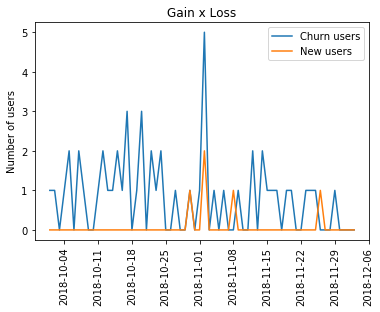

In [24]:
plt.plot(new_x_churn['day'], new_x_churn['churnUsers'], label = "Churn users")
plt.plot(new_x_churn['day'], new_x_churn['newUsers'], label = "New users")
plt.title('Gain x Loss')
plt.ylabel('Number of users')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [25]:
spark.sql('''
            SELECT DISTINCT level
            FROM clean_user_log_table
            '''
         ).show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



How many active free and paid users do we have by day? Did the amount of paid users grow across the time?

In [26]:
# Convert timestamp field in datetime
valid_log = valid_log.withColumn('occurred_at', from_unixtime((col('ts')/1000), 'yyyy-MM-dd HH:mm:ss'))
valid_log.createOrReplaceTempView('clean_user_log_table')

In [27]:
paid_users = spark.sql('''
            SELECT DATE_TRUNC("day", occurred_at) AS day,
                COUNT(DISTINCT userID) AS paidUsers
            FROM clean_user_log_table
            WHERE level = "paid"
            GROUP BY 1
            ORDER BY 1
            '''
         ).toPandas()

free_users = spark.sql('''
            SELECT DATE_TRUNC("day", occurred_at) AS day,
                COUNT(DISTINCT userID) AS freeUsers
            FROM clean_user_log_table
            WHERE level = "free"
            GROUP BY 1
            ORDER BY 1
            '''
         ).toPandas()

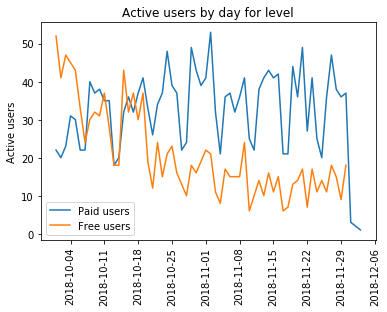

In [28]:
# plotting the curves for active users in the app for free and paid ones by each day
plt.plot(paid_users['day'], paid_users['paidUsers'], label = "Paid users")
plt.plot(free_users['day'], free_users['freeUsers'], label = "Free users")
plt.title('Active users by day for level')
plt.ylabel('Active users')
plt.xticks(rotation=90)
plt.legend()
plt.show()

The number of active free users declines over time in the app. Could these free users be becoming paid users?

In [29]:
upgrade_amt = spark.sql('''
            SELECT DATE_TRUNC('day', occurred_at) AS day,
                COUNT(DISTINCT userID) AS upgrade_amt
            FROM clean_user_log_table
            WHERE page = "Submit Upgrade"
            GROUP BY 1
            ORDER BY 1
            '''
         ).toPandas()

downgrade_amt = spark.sql('''
            SELECT DATE_TRUNC('day', occurred_at) AS day,
                COUNT(DISTINCT userID) AS downgrade_amt
            FROM clean_user_log_table
            WHERE page = "Submit Downgrade"
            GROUP BY 1
            ORDER BY 1
            '''
         ).toPandas()

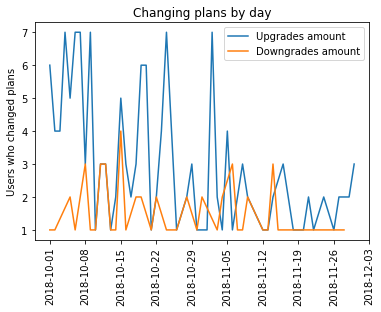

In [30]:
# plotting the curves for upgrade and downgrade plans by each day
plt.plot(upgrade_amt['day'], upgrade_amt['upgrade_amt'], label = "Upgrades amount")
plt.plot(downgrade_amt['day'], downgrade_amt['downgrade_amt'], label = "Downgrades amount")
plt.title('Changing plans by day')
plt.ylabel('Users who changed plans')
plt.xticks(rotation=90)
plt.legend()
plt.show()

The number of plans upgraded  by day is very expressive until near October 29, which explains the higher number of paid users compared to free ones close to this date and beyond (showed in the previous plot). The number of upgrades is much higher than the downgrades, which is great too. Considering the two groups we have: users who canceled the streaming music service and users who stayed. How many of the users are free and paid by each of these groups?

In [31]:
level_churn = spark.sql('''
            SELECT DISTINCT(a.userID), b.lastAccess, a.level, c.isChurn
            FROM clean_user_log_table AS a
            RIGHT JOIN (
                SELECT userID,
                    MAX(occurred_at) lastAccess
                FROM clean_user_log_table
                GROUP BY 1
            ) AS b
            ON a.userID = b.userID AND a.occurred_at = b.lastAccess
            JOIN churn_user_table c
            ON c.userID = a.userID
            ORDER BY 1
            '''
         )

In [32]:
level_churn.toPandas().head(20)

,userID,lastAccess,level,isChurn
0,10,2018-11-19 12:49:48,paid,0
1,100,2018-11-30 14:15:49,paid,0
2,100001,2018-10-02 16:36:45,free,1
3,100002,2018-12-03 01:11:16,paid,0
4,100003,2018-10-11 16:19:41,free,1
5,100004,2018-11-29 02:37:45,paid,0
6,100005,2018-10-19 17:57:05,free,1
7,100006,2018-10-05 15:24:30,free,1
8,100007,2018-11-29 11:45:09,paid,1
9,100008,2018-11-27 16:13:39,free,0


In [33]:
# Counting how many users paid and free are in the two groups?
level_churn.createOrReplaceTempView('level_churn_table')
level_df = spark.sql('''
            SELECT isChurn, SUM(paid) AS paid, SUM(free) as free
            FROM (
                SELECT userID, isChurn,
                        (CASE WHEN level = "paid" THEN 1 ELSE 0 END) AS paid,                    
                        (CASE WHEN level = "free" THEN 1 ELSE 0 END) AS free
                FROM level_churn_table)
            GROUP BY 1
            '''
         ).toPandas()
level_df

,isChurn,paid,free
0,0,114,59
1,1,31,21


In [34]:
# Converting theses values in percentage
level_df['paid'] = level_df['paid'] * 100 / np.sum(level_df['paid'])
level_df['free'] = level_df['free'] * 100 / np.sum(level_df['free'])
level_df.drop('isChurn', axis=1, inplace=True)
level_df.set_index(pd.Index(['Stayed', 'Churned']), inplace=True)
level_df

,paid,free
Stayed,78.62069,73.75
Churned,21.37931,26.25


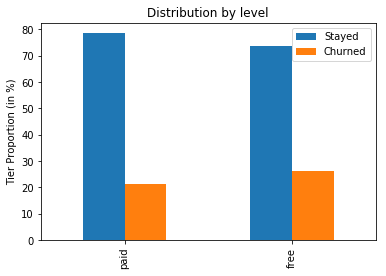

In [35]:
level_df.transpose().plot(kind='bar', title='Distribution by level')
plt.ylabel('Tier Proportion (in %)');

# Feature Engineering

Let’s try out some measures to understand how the behaviour of users is, and adding some of them to our data model. First, we can see that free users are bit more susceptible to churn than paid ones. Could the advertising average by session be related to it? First, let's use this feature in our data model!

In [36]:
model_data = spark.sql('''
                            SELECT userID, level, isChurn
                            FROM level_churn_table
                        '''
                      )
model_data.createOrReplaceTempView('model_data')

In [37]:
spark.sql('''
            SELECT a.userID, a.advertising, b.level, b.isChurn
            FROM (
                SELECT userID,
                        SUM(CASE WHEN page = "Roll Advert" THEN 1 ELSE 0 END) AS advertising
                FROM clean_user_log_table
                GROUP BY 1
                ) AS a
            JOIN level_churn_table AS b
            ON a.userID = b.userID
            ORDER BY 4 DESC, 2 DESC
            '''
         ).show()

+------+-----------+-----+-------+
|userID|advertising|level|isChurn|
+------+-----------+-----+-------+
|100022|        115| free|      1|
|100015|         69| paid|      1|
|200020|         69| free|      1|
|    87|         50| paid|      1|
|    54|         47| paid|      1|
|100009|         42| free|      1|
|100013|         39| paid|      1|
|100012|         38| free|      1|
|200018|         32| free|      1|
|100025|         30| free|      1|
|100021|         30| free|      1|
|   121|         28| paid|      1|
|200024|         27| paid|      1|
|200011|         27| free|      1|
|    28|         26| paid|      1|
|    53|         25| paid|      1|
|    29|         22| paid|      1|
|200015|         22| free|      1|
|    12|         21| paid|      1|
|200016|         18| free|      1|
+------+-----------+-----+-------+
only showing top 20 rows



Since a user could downgrade or upgrade the service, the same user could have two phases in the log: the free and paid, whereas the “canceled confirmation” could happen in one of these phases. So, let’s separate the answer in these two phases: free and paid.

In [38]:
free_advertising = spark.sql('''
            SELECT userID, AVG(advertising) avgFreeAdvertising, 
                    MAX(lastSessionDate) lastFreeAccess, SUM(isChurn) isChurn
            FROM (
                SELECT userID, sessionID,
                     SUM(CASE WHEN page = "Roll Advert" THEN 1 ELSE 0 END) AS advertising,
                     MAX(occurred_at) lastSessionDate,
                     SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                WHERE level = "free"
                GROUP BY 1, 2
                )
            GROUP BY 1
            ORDER BY 3 DESC, 2 DESC
            ''')

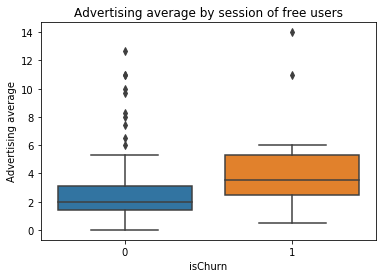

In [39]:
# visualize the distribution of advertising average by session of free users for both groups
sns.boxplot(y="avgFreeAdvertising", x="isChurn", data=free_advertising.toPandas())
plt.title('Advertising average by session of free users')
plt.ylabel('Advertising average')
plt.show()

In [40]:
paid_advertising = spark.sql('''
            SELECT userID, AVG(advertising) avgPaidAdvertising, 
                    MAX(lastSessionDate) lastPaidAccess, SUM(isChurn) isChurn
            FROM (
                SELECT userID, sessionID,
                     SUM(CASE WHEN page = "Roll Advert" THEN 1 ELSE 0 END) AS advertising,
                     MAX(occurred_at) lastSessionDate,
                     SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                WHERE level = "paid"
                GROUP BY 1, 2
                )
            GROUP BY 1
            ORDER BY 3 DESC, 2 DESC
            ''')

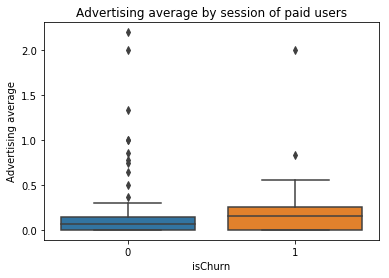

In [41]:
# visualize the distribution of advertising average by session of paid users for both groups
sns.boxplot(y="avgPaidAdvertising", x="isChurn", data=paid_advertising.toPandas())
plt.title('Advertising average by session of paid users')
plt.ylabel('Advertising average')
plt.show()

Before adding this measure to our model data, it’s necessary to treat it to get just the advertising for the last period level, i. e, if the user was free and upgraded to a paid account, we have to use the advertising average just for the paid period.

In [42]:
free_advertising.createOrReplaceTempView('free_advertising')
paid_advertising.createOrReplaceTempView('paid_advertising')
advertising = spark.sql('''
            SELECT 
                (CASE WHEN p.userID IS NOT NULL THEN p.userID ELSE f.userID END) AS userID, 
                (CASE WHEN lastPaidAccess IS NULL THEN avgFreeAdvertising
                    WHEN lastFreeAccess IS NULL THEN avgPaidAdvertising
                    WHEN lastPaidAccess > lastFreeAccess THEN avgPaidAdvertising 
                    ELSE avgFreeAdvertising END) AS advertising
            FROM paid_advertising AS p
            FULL OUTER JOIN free_advertising AS f
            ON p.userID = f.userID
            ORDER BY 1
            ''').toPandas()

In [43]:
model_data = model_data.toPandas()
model_data = model_data.set_index('userID')
advertising = model_data.join(advertising.set_index('userID'))

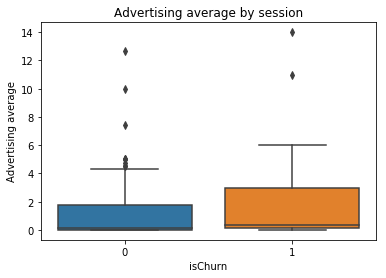

In [44]:
# visualize the distribution of advertising average by session for both groups
sns.boxplot(y="advertising", x="isChurn", data=advertising)
plt.title('Advertising average by session')
plt.ylabel('Advertising average')
plt.show()

Now with the advertising average isolated, it’s cleaner the effect of advertising on churned users. Let’s add this measure to our data model and find out if “Submit downgrade” could be either related to churn. 

In [45]:
model_data = advertising

In [46]:
downgrade = spark.sql('''
                    SELECT a.userID, a.isDowngraded, b.isChurn
                    FROM (
                        SELECT userID,
                             MAX(CASE WHEN page = "Submit Downgrade" THEN 1 ELSE 0 END) AS isDowngraded
                        FROM clean_user_log_table
                        WHERE level = "paid"
                        GROUP BY 1) AS a
                    JOIN churn_user_table AS b
                    ON a.userID = b.userID
                    ORDER BY 3 DESC, 2 DESC
                '''
            ).toPandas()

In [47]:
values = [[downgrade.query('isDowngraded == 0 & isChurn == 0').shape[0],
           downgrade.query('isDowngraded == 0 & isChurn == 1').shape[0]],
          [downgrade.query('isDowngraded == 1 & isChurn == 0').shape[0],
           downgrade.query('isDowngraded == 1 & isChurn == 1').shape[0]]]
downgrade = pd.DataFrame(values, index=['Stayed', 'Churned'], columns=['Not Downgrade', 'Downgrade'])
downgrade

,Not Downgrade,Downgrade
Stayed,89,27
Churned,40,9


In [48]:
downgrade['Not Downgrade'] = downgrade['Not Downgrade'] * 100 / np.sum(downgrade['Not Downgrade'])
downgrade['Downgrade'] = downgrade['Downgrade'] * 100 / np.sum(downgrade['Downgrade'])
downgrade

,Not Downgrade,Downgrade
Stayed,68.992248,75.0
Churned,31.007752,25.0


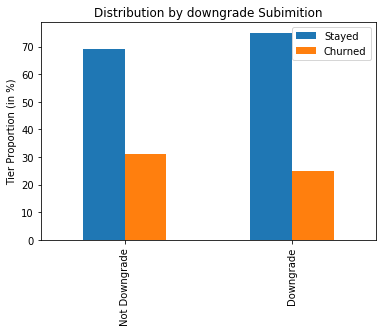

In [49]:
# visualize the distribution of downgrade submition by paid users for both groups
downgrade.transpose().plot(kind='bar', title='Distribution by downgrade Subimition')
plt.ylabel('Tier Proportion (in %)');

Looking at the above plot, we can see that people who downgraded have more chances to stay compared to who didn’t. Inserting this data to our data model could teach wrong patterns to our model, since we don’t want users to downgrade. Let’s see the distribution for thumbs up and thumbs down average by session.

In [50]:
thumbs_up = spark.sql('''
                SELECT userID, AVG(thumbsUpAmt) avgThumbsUp, SUM(isChurn) isChurn
                FROM (
                    SELECT userID, sessionID,
                         SUM(CASE WHEN page = "Thumbs Up" THEN 1 ELSE 0 END) AS thumbsUpAmt,
                         SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    GROUP BY 1, 2
                    )
                GROUP BY 1
                ORDER BY 3 DESC, 2 DESC
            '''
        ).toPandas()

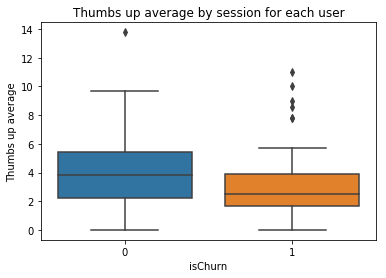

In [51]:
# visualize the distribution of thumbs up average by session for each user for both groups
sns.boxplot(y="avgThumbsUp", x="isChurn", data=thumbs_up)
plt.title('Thumbs up average by session for each user')
plt.ylabel('Thumbs up average')
plt.show()

In [52]:
model_data = model_data.join(thumbs_up[['userID', 'avgThumbsUp']].set_index('userID'))

In [53]:
thumbs_down = spark.sql('''
                SELECT userID, AVG(thumbsDownAmt) avgThumbsDown, SUM(isChurn) isChurn
                FROM (
                    SELECT userID, sessionID,
                         SUM(CASE WHEN page = "Thumbs Down" THEN 1 ELSE 0 END) AS thumbsDownAmt,
                         SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    GROUP BY 1, 2
                    )
                GROUP BY 1
                ORDER BY 3 DESC, 2 DESC
            '''
        ).toPandas()

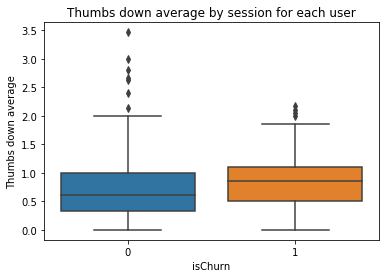

In [54]:
# visualize the distribution of thumbs down average by session for each user for both groups
sns.boxplot(y="avgThumbsDown", x="isChurn", data=thumbs_down)
plt.title('Thumbs down average by session for each user')
plt.ylabel('Thumbs down average')
plt.show()

In [55]:
model_data = model_data.join(thumbs_down[['userID', 'avgThumbsDown']].set_index('userID'))

If we assume that users who really like this streaming music service and his song recommendations, would accumulate a Thumbs up proportion much greater than Thumbs down. Wouldn't you think?

In [56]:
proportion_thumbsDown = spark.sql('''
                SELECT userID, (thumbsDownAmt / (thumbsUpAmt + thumbsDownAmt)) thumbsDownProportion, isChurn
                FROM (
                    SELECT userID,
                         SUM(CASE WHEN page = "Thumbs Up" THEN 1 ELSE 0 END) AS thumbsUpAmt,
                         SUM(CASE WHEN page = "Thumbs Down" THEN 1 ELSE 0 END) AS thumbsDownAmt,
                         SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    GROUP BY 1
                    )
                ORDER BY 3 DESC, 2 DESC
            '''
        ).toPandas()

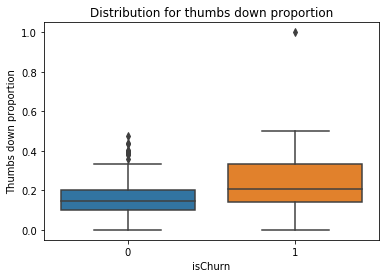

In [57]:
# visualize the distribution of thumbs down proportion by both groups
sns.boxplot(y="thumbsDownProportion", x="isChurn", data=proportion_thumbsDown)
plt.title('Distribution for thumbs down proportion')
plt.ylabel('Thumbs down proportion')
plt.show()

In [58]:
model_data = model_data.join(proportion_thumbsDown[['userID', 'thumbsDownProportion']].set_index('userID'))

Let's analyze the average songs played per session.

In [59]:
num_songs_by_session = spark.sql('''
            SELECT userID, AVG(numSongs) avgNumSongs, SUM(isChurn) isChurn
            FROM (
                SELECT userID, sessionID,
                    SUM(CASE WHEN page = "NextSong" THEN 1 ELSE 0 END) AS numSongs,
                    SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                GROUP BY 1, 2)
            GROUP BY 1
            ORDER BY 3, 2 DESC
            '''
         ).toPandas()

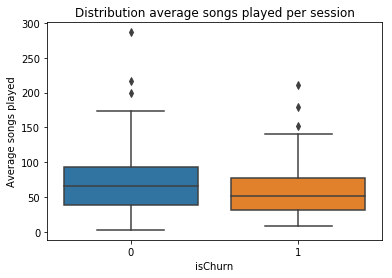

In [60]:
# visualize the distribution of average songs played per session by both groups
sns.boxplot(y="avgNumSongs", x="isChurn", data=num_songs_by_session)
plt.title('Distribution average songs played per session')
plt.ylabel('Average songs played')
plt.show()

In [61]:
model_data = model_data.join(num_songs_by_session[['userID', 'avgNumSongs']].set_index('userID'))

Another good measure could be the average time spent per session. The hypothesis is that users who spend more time per session in the system tend to be more satisfied users and less prone to churn.

In [62]:
session_duration = spark.sql('''
            SELECT userID, avg(session_duration) avgSessionDuration, SUM(isChurn) isChurn
            FROM (
                SELECT userID, sessionID, MIN(occurred_at) initial_time, MAX(occurred_at) final_time,
                    (UNIX_TIMESTAMP(MAX(occurred_at)) - UNIX_TIMESTAMP(MIN(occurred_at))) session_duration,
                    SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                GROUP BY 1, 2
                )
            GROUP BY 1
            ORDER BY 3, 2 DESC
            '''
         ).toPandas()

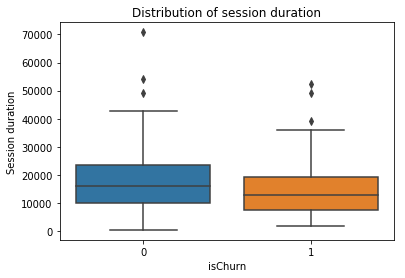

In [63]:
# visualize the distribution of session duration for both groups
sns.boxplot(y="avgSessionDuration", x="isChurn", data=session_duration)
plt.title('Distribution of session duration')
plt.ylabel('Session duration')
plt.show()

In [64]:
model_data = model_data.join(session_duration[['userID', 'avgSessionDuration']].set_index('userID'))

Let’s analyze the “Add Playlist” and "Add Friend" events. The hypothesis is that users who add more songs to a playlists or add more friends by each session tend to be less prone to not churn.

In [65]:
num_playlist_addition_by_session = spark.sql('''
            SELECT userID, AVG(numPlaylistAddition) avgNumPlaylistAddition, SUM(isChurn) isChurn
            FROM (
                SELECT userID, sessionID,
                    SUM(CASE WHEN page = "Add to Playlist" THEN 1 ELSE 0 END) AS numPlaylistAddition,
                    SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                GROUP BY 1, 2)
            GROUP BY 1
            ORDER BY 3 DESC, 2 DESC
            '''
         ).toPandas()

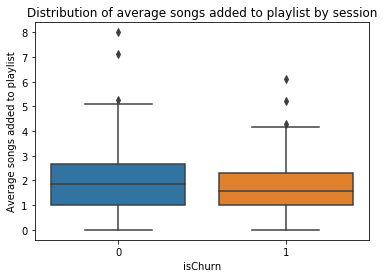

In [66]:
# visualize the distribution of average songs added to playlist per session by both groups
sns.boxplot(y="avgNumPlaylistAddition", x="isChurn", data=num_playlist_addition_by_session)
plt.title('Distribution of average songs added to playlist by session')
plt.ylabel('Average songs added to playlist')
plt.show()

In [67]:
model_data = model_data.join(num_playlist_addition_by_session[['userID', 'avgNumPlaylistAddition']].set_index('userID'))

In [68]:
num_friends_added_by_session = spark.sql('''
            SELECT userID, AVG(numFriendsAdded) avgNumFriendsAdded, SUM(isChurn) isChurn
            FROM (
                SELECT userID, sessionID,
                    SUM(CASE WHEN page = "Add Friend" THEN 1 ELSE 0 END) AS numFriendsAdded,
                    SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                GROUP BY 1, 2)
            GROUP BY 1
            ORDER BY 3 DESC, 2 DESC
            '''
         ).toPandas()

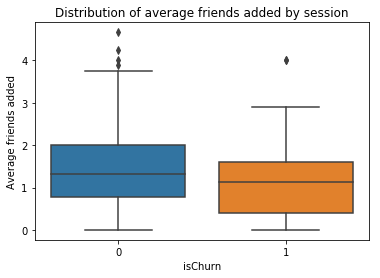

In [69]:
# visualize the distribution of average friends added per session by both groups
sns.boxplot(y="avgNumFriendsAdded", x="isChurn", data=num_friends_added_by_session)
plt.title('Distribution of average friends added by session')
plt.ylabel('Average friends added')
plt.show()

In [70]:
model_data = model_data.join(num_friends_added_by_session[['userID', 'avgNumFriendsAdded']].set_index('userID'))

Another measure that could be the average time between one session and another.

In [71]:
session_duration = spark.sql('''
            SELECT userID, AVG(timeBetweenSessions) avgTimeBetweenSessions, SUM(isChurn) isChurn
            FROM (
                SELECT userID, sessionID, initial_time, final_time, isChurn,
                    UNIX_TIMESTAMP(LEAD(initial_time) OVER (PARTITION BY userID ORDER BY initial_time)) - UNIX_TIMESTAMP(final_time) AS timeBetweenSessions
                FROM (
                    SELECT userID, sessionID, MIN(occurred_at) initial_time, MAX(occurred_at) final_time,
                        SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    GROUP BY 1, 2
                    )
                ORDER BY 1, 3
                )
            GROUP BY 1
            ORDER BY 3, 2 DESC
            '''
         ).toPandas()

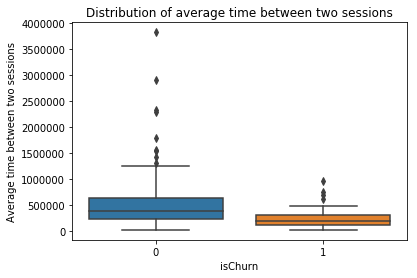

In [72]:
# visualize the distribution of average time between two sessions by both groups
sns.boxplot(y="avgTimeBetweenSessions", x="isChurn", data=session_duration)
plt.title('Distribution of average time between two sessions')
plt.ylabel('Average time between two sessions')
plt.show()

In [73]:
model_data = model_data.join(session_duration[['userID', 'avgTimeBetweenSessions']].set_index('userID'))

In [74]:
spark.sql('''
            SELECT DISTINCT(gender)
            FROM clean_user_log_table
            '''
         ).toPandas()

,gender
0,F
1,M


Let’s analyze how genres relate to churn.

In [75]:
# Counting how many users paid and free are in the two groups?
genre_df = spark.sql('''
            SELECT isChurn, SUM(isMale) AS male, COUNT(*) - SUM(isMale) AS female
            FROM (
                SELECT userID,
                        CASE WHEN gender = "M" THEN 1 ELSE 0 END isMale,
                        SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                GROUP BY 1, 2
            )
            GROUP BY 1
            '''
         ).toPandas()
genre_df

,isChurn,male,female
0,0,89,84
1,1,32,20


In [76]:
# Converting theses values in percentage
genre_df['male'] = genre_df['male'] * 100 / np.sum(genre_df['male'])
genre_df['female'] = genre_df['female'] * 100 / np.sum(genre_df['female'])
genre_df.drop('isChurn', axis=1, inplace=True)
genre_df.set_index(pd.Index(['Stayed', 'Churned']), inplace=True)
genre_df

,male,female
Stayed,73.553719,80.769231
Churned,26.446281,19.230769


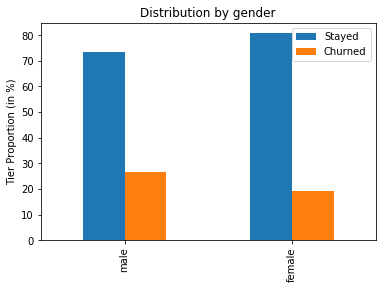

In [77]:
genre_df.transpose().plot(kind='bar', title='Distribution by gender')
plt.ylabel('Tier Proportion (in %)');

In [78]:
genre = spark.sql('''
                SELECT userID,
                        gender,
                        SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                GROUP BY 1, 2
            '''
         ).toPandas()

In [79]:
model_data = model_data.join(genre[['userID', 'gender']].set_index('userID'))

In [80]:
spark.sql('''
            SELECT DISTINCT(userAgent)
            FROM clean_user_log_table
            '''
         ).collect()

[Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW6

User agent is a way to find information about the browser and device Operational System the user is using. So taking in consideration that web apps should be prepared to work with different browsers, we should cross this info with the churn element to see how they are related. Chrome and Safari always appear together with AppleWebKit, so let’s use AppleWebKit to refer to these web browsers. Firefox appears to Linux, Windows and Macintosh. AppleWebKit appears to all OS and Trident appears just to Windows. So, we have 9 different classes.

In [81]:
user_agent = spark.sql('''
            SELECT isChurn,
                    SUM(Windows_Firefox) Windows_Firefox,
                    SUM(Linux_Firefox) Linux_Firefox,
                    SUM(Macintosh_Firefox) Macintosh_Firefox,
                    SUM(Macintosh_AppleWebKit) Macintosh_AppleWebKit,
                    SUM(Linux_AppleWebKit) Linux_AppleWebKit,
                    SUM(Windows_AppleWebKit) Windows_AppleWebKit,
                    SUM(iPhone_AppleWebKit) iPhone_AppleWebKit,
                    SUM(iPad_AppleWebKit) iPad_AppleWebKit,
                    SUM(Windows_Trident) Windows_Trident
            FROM (         
                SELECT userID,
                    AVG(CASE WHEN userAgent LIKE "%Windows%Firefox%" THEN 1 ELSE 0 END) AS Windows_Firefox,
                    AVG(CASE WHEN userAgent LIKE "%Linux%Firefox%" THEN 1 ELSE 0 END) AS Linux_Firefox,
                    AVG(CASE WHEN userAgent LIKE "%Macintosh%Firefox%" THEN 1 ELSE 0 END) AS Macintosh_Firefox,
                    AVG(CASE WHEN userAgent LIKE "%Macintosh%AppleWebKit%" THEN 1 ELSE 0 END) AS Macintosh_AppleWebKit,
                    AVG(CASE WHEN userAgent LIKE "%Windows%AppleWebKit%" THEN 1 ELSE 0 END) AS Windows_AppleWebKit,
                    AVG(CASE WHEN userAgent LIKE "%Linux%AppleWebKit%" THEN 1 ELSE 0 END) AS Linux_AppleWebKit,
                    AVG(CASE WHEN userAgent LIKE "%iPhone%AppleWebKit%" THEN 1 ELSE 0 END) AS iPhone_AppleWebKit,
                    AVG(CASE WHEN userAgent LIKE "%iPad%AppleWebKit%" THEN 1 ELSE 0 END) AS iPad_AppleWebKit,
                    AVG(CASE WHEN userAgent LIKE "%Trident%" THEN 1 ELSE 0 END) AS Windows_Trident,
                    SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                GROUP BY 1)
            GROUP BY 1
            '''
         ).toPandas()

In [82]:
for column in user_agent.columns.tolist():
    user_agent[column] = user_agent[column] * 100 / np.sum(user_agent[column])

user_agent.drop('isChurn', axis=1, inplace=True)
user_agent.set_index(pd.Index(['Stayed', 'Churned']), inplace=True)
user_agent.transpose()

,Stayed,Churned
Windows_Firefox,70.967742,29.032258
Linux_Firefox,33.333333,66.666667
Macintosh_Firefox,76.923077,23.076923
Macintosh_AppleWebKit,78.082192,21.917808
Linux_AppleWebKit,83.333333,16.666667
Windows_AppleWebKit,79.411765,20.588235
iPhone_AppleWebKit,69.230769,30.769231
iPad_AppleWebKit,100.000000,0.000000
Windows_Trident,91.666667,8.333333


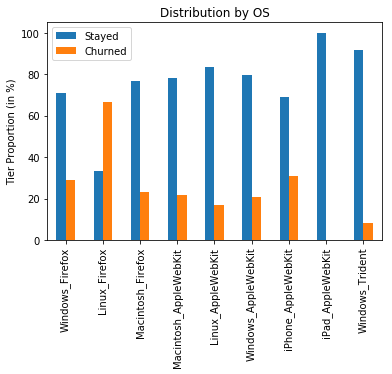

In [83]:
user_agent.transpose().plot(kind='bar', title='Distribution by OS')
plt.ylabel('Tier Proportion (in %)');

In [84]:
user_agent = spark.sql('''
            SELECT userID,
                CASE WHEN userAgent LIKE "%Windows%Firefox%" THEN "Windows_Firefox"
                     WHEN userAgent LIKE "%Linux%Firefox%" THEN "Linux_Firefox"
                     WHEN userAgent LIKE "%Macintosh%Firefox%" THEN "Macintosh_Firefox"
                     WHEN userAgent LIKE "%Macintosh%AppleWebKit%" THEN "Macintosh_AppleWebKit"
                     WHEN userAgent LIKE "%Windows%AppleWebKit%" THEN "Windows_AppleWebKit"
                     WHEN userAgent LIKE "%Linux%AppleWebKit%" THEN "Linux_AppleWebKit"
                     WHEN userAgent LIKE "%iPhone%AppleWebKit%" THEN "iPhone_AppleWebKit"
                     WHEN userAgent LIKE "%iPad%AppleWebKit%" THEN "iPad_AppleWebKit"
                     ELSE "Windows_Trident" END AS userAgent,
                SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
            FROM clean_user_log_table
            GROUP BY 1, 2
            '''
         ).toPandas()

In [85]:
model_data = model_data.join(user_agent[['userID', 'userAgent']].set_index('userID'))

The average time between two songs played could be a relevant measure.

In [86]:
time_between_songs = spark.sql('''
                SELECT a.userID, a.avgTimeDiffBetweenSongs, b.isChurn
                FROM (
                    SELECT userID,
                        AVG(UNIX_TIMESTAMP(nextSongTime) - UNIX_TIMESTAMP(songTime)) AS avgTimeDiffBetweenSongs
                    FROM (
                        SELECT userID, occurred_at AS songTime,
                            LEAD(occurred_at) OVER (PARTITION BY userID ORDER BY occurred_at) AS nextSongTime
                        FROM (
                            SELECT userID, occurred_at,
                                (CASE WHEN page = "NextSong" THEN 1 ELSE 0 END) AS song
                            FROM clean_user_log_table)
                        WHERE song = 1)
                    GROUP BY 1) AS a
                JOIN churn_user_table AS b
                ON a.userID = b.userID
                ORDER BY 3, 2 DESC
            '''
         ).toPandas()

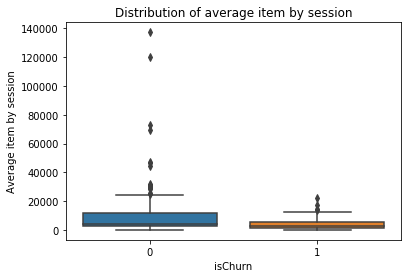

In [87]:
# visualize the distribution of average time between two sessions by both groups
sns.boxplot(y="avgTimeDiffBetweenSongs", x="isChurn", data=time_between_songs)
plt.title('Distribution of average item by session')
plt.ylabel('Average item by session')
plt.show()

In [88]:
model_data = model_data.join(time_between_songs[['userID', 'avgTimeDiffBetweenSongs']].set_index('userID'))

In [89]:
model_data.head()

,level,isChurn,advertising,avgThumbsUp,avgThumbsDown,thumbsDownProportion,avgNumSongs,avgSessionDuration,avgNumPlaylistAddition,avgNumFriendsAdded,avgTimeBetweenSessions,gender,userAgent,avgTimeDiffBetweenSongs
userID,,,,,,,,,,,,,,
10,paid,0,0.166667,6.166667,0.666667,0.097561,112.166667,27584.833333,1.500000,2.00,7.002118e+05,M,Macintosh_AppleWebKit,5456.150298
100,paid,0,0.137931,4.228571,0.771429,0.154286,76.628571,18991.142857,1.742857,1.40,1.302940e+05,M,Windows_Firefox,1900.292055
100001,free,1,3.500000,2.000000,0.500000,0.200000,33.250000,8889.500000,0.750000,0.50,2.871433e+04,F,Macintosh_AppleWebKit,920.628788
100002,paid,0,0.750000,1.250000,0.000000,0.000000,48.750000,12071.000000,1.250000,0.25,1.570582e+06,F,Windows_Firefox,24536.195876
100003,free,1,4.500000,1.500000,0.000000,0.000000,25.500000,5947.000000,1.000000,0.00,1.624670e+05,F,Windows_Firefox,3487.100000


In [90]:
model_data.describe()

,isChurn,advertising,avgThumbsUp,avgThumbsDown,thumbsDownProportion,avgNumSongs,avgSessionDuration,avgNumPlaylistAddition,avgNumFriendsAdded,avgTimeBetweenSessions,avgTimeDiffBetweenSongs
count,225.000000,225.000000,225.000000,225.000000,221.000000,225.000000,225.000000,225.000000,225.000000,2.100000e+02,225.000000
mean,0.231111,1.247396,3.735060,0.765844,0.176896,69.002331,17289.959044,1.929065,1.373669,4.689066e+05,8961.479990
std,0.422483,2.114283,2.325835,0.589862,0.121938,42.320954,10610.546683,1.277232,0.940729,4.678903e+05,15309.850365
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,420.000000,0.000000,0.000000,2.871433e+04,209.000000
25%,0.000000,0.000000,2.000000,0.375000,0.105263,35.857143,9682.625000,1.000000,0.750000,2.054402e+05,2385.431104
50%,0.000000,0.166667,3.500000,0.666667,0.156250,64.200000,15924.250000,1.800000,1.250000,3.190955e+05,4011.485577
75%,0.000000,2.000000,5.000000,1.000000,0.215517,91.714286,22889.000000,2.617647,1.800000,5.976158e+05,10227.346405
max,1.000000,14.000000,13.777778,3.466667,1.000000,286.666667,70794.000000,8.000000,4.666667,3.831080e+06,137097.464286


In [91]:
# Checking for nan values
model_data.isna().sum()

level                       0
isChurn                     0
advertising                 0
avgThumbsUp                 0
avgThumbsDown               0
thumbsDownProportion        4
avgNumSongs                 0
avgSessionDuration          0
avgNumPlaylistAddition      0
avgNumFriendsAdded          0
avgTimeBetweenSessions     15
gender                      0
userAgent                   0
avgTimeDiffBetweenSongs     0
dtype: int64

In [92]:
# Fill nan for 0, since: 
# 1. Who haven't time between session is a user who have just one session
# 2. Who haven't thumbs down proportion is because the user didn't gave any thumbs
model_data['avgTimeBetweenSessions'] = model_data['avgTimeBetweenSessions'].fillna(0)
model_data['thumbsDownProportion'] = model_data['thumbsDownProportion'].fillna(0)
model_data.rename(columns = {'isChurn': 'label'}, inplace = True)

# Convert the dataframe
model_df = spark.createDataFrame(model_data.values.tolist(), list(model_data.columns))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [93]:
# Building the pipeline to prepare the data to fit, 
# adding string indexer for categorial columns

features = ['level_index',
           'gender_index',
           'user_agent_index',
           'advertising', 
           'avgThumbsUp',
           'avgThumbsDown', 
           'thumbsDownProportion', 
           'avgNumSongs', 
           'avgSessionDuration',
           'avgNumPlaylistAddition', 
           'avgNumFriendsAdded',
           'avgTimeBetweenSessions',                                          
           'avgTimeDiffBetweenSongs'                                           
           ]

indexer_gender = StringIndexer(inputCol='gender', outputCol='gender_index')
indexer_level = StringIndexer(inputCol='level', outputCol='level_index')
indexer_user_agent = StringIndexer(inputCol='userAgent', outputCol='user_agent_index')
vec_assembler = VectorAssembler(inputCols=features, outputCol='features')

pipeline = Pipeline(stages=[indexer_gender, indexer_level, indexer_user_agent, vec_assembler])
treated_data = pipeline.fit(model_df).transform(model_df)

In [94]:
# Checking for sparse vectors
feature_vector = treated_data.select('features').collect()
sparseVectors = list(filter(lambda x: type(x[0]) is SparseVector, feature_vector))

print('Number of Sparse vectors: {}'.format(len(sparseVectors)))

Number of Sparse vectors: 7


In [95]:
# Let's convert sparse vectors to dense vectors to improve the learning methods
data_to_use = treated_data.select('label', 'features')
data_to_use = data_to_use.rdd.map(lambda x: Row(label=x[0], features = DenseVector(x[1].toArray())))
treated_data = spark.createDataFrame(data_to_use)

In [96]:
# Split this data between train and test sets
train, test = treated_data.randomSplit([0.8, 0.2], seed=42)
train.head()

Row(features=DenseVector([0.0, 0.0, 0.0, 0.0, 1.1667, 0.0, 0.0, 23.1667, 5243.8333, 0.8333, 0.5, 440463.0, 16186.4565]), label=0)

In [99]:
'''
Since some of our feature have values in a much greater scale, 
it's necessary scaling the feature vector.
'''
min_max_scaler = MinMaxScaler(inputCol='features', outputCol='scaledFeatures')

'''
As the plan is to use the cross validation to hyper-tune the parameters, 
scaling the set before cross validation could cause the data leakage. 
The recommendation is to use a pipeline to scaling the data in a pre processor 
step, since cross validation divides the train set into two new sets, one to 
train and other to validate.
'''

logit = LogisticRegression()
pipe_logit = Pipeline(stages=[min_max_scaler, logit])

randomForest = RandomForestClassifier(seed=42)
pipe_randomForest = Pipeline(stages=[min_max_scaler, randomForest])

gbt = GBTClassifier(maxIter=20, seed=42)
pipe_gbt = Pipeline(stages=[min_max_scaler, gbt])

In [100]:
# Let's tuning the Logistic Regression model by regularization rate
param_grid = ParamGridBuilder() \
    .addGrid(logit.regParam, [0.05, 0.1, 0.2, 0.5]) \
    .build()
    
cv_logit = CrossValidator(estimator = pipe_logit,
                       estimatorParamMaps = param_grid,
                       evaluator = MulticlassClassificationEvaluator(),
                       numFolds = 3,
                       seed = 42
                      )
cv_model_logit = cv_logit.fit(train)

In [107]:
logit_results = cv_model_logit.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
logit_accuracy = evaluator.evaluate(logit_results, {evaluator.metricName: "accuracy"})
logit_f1_score = evaluator.evaluate(logit_results, {evaluator.metricName: "f1"})

print("Accuracy for Logistic Regression Model is: {}".format(logit_accuracy))
print("F1 Score for Logistic Regression Model is: {}".format(logit_f1_score))

Accuracy for Logistic Regression Model is: 0.875
F1 Score for Logistic Regression Model is: 0.8616071428571429


In [111]:
# Let's tuning the Random Forest Classifier
param_grid = ParamGridBuilder() \
    .addGrid(randomForest.minInfoGain, [0, 1]) \
    .addGrid(randomForest.numTrees, [15, 30, 50]) \
    .addGrid(randomForest.maxDepth, [10, 20]) \
    .build()

cv_rforest = CrossValidator(estimator = pipe_randomForest,
                         estimatorParamMaps = param_grid,
                         evaluator = MulticlassClassificationEvaluator(),
                         numFolds = 3,
                         seed = 42
                        )
cv_model_rforest = cv_rforest.fit(train)

In [112]:
rforest_results = cv_model_rforest.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
rforest_accuracy = evaluator.evaluate(rforest_results, {evaluator.metricName: "accuracy"})
rforest_f1_score = evaluator.evaluate(rforest_results, {evaluator.metricName: "f1"})

print("Accuracy for Random Forest Classifier Model is: {}".format(rforest_accuracy))
print("F1 Score for Random Forest Classifier Model is: {}".format(rforest_f1_score))

Accuracy for Random Forest Classifier Model is: 0.90625
F1 Score for Random Forest Classifier Model is: 0.9018939393939394


In [113]:
# Let's tuning the Gradient Boosted Tree
paramGrid = ParamGridBuilder() \
            .addGrid(gbt.minInstancesPerNode, [5, 10, 20, 50]) \
            .addGrid(gbt.maxDepth, [9, 11, 13])\
            .addGrid(gbt.subsamplingRate, [0.5, 0.75, 1.0])\
            .build()

cv_gbt = CrossValidator(estimator = pipe_gbt,
                        estimatorParamMaps = paramGrid,
                        evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                        numFolds = 3,
                        seed = 42
                       )
cv_model_gbt = cv_gbt.fit(train)

In [114]:
gbt_results = cv_model_gbt.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
gbt_accuracy = evaluator.evaluate(gbt_results, {evaluator.metricName: "accuracy"})
gbt_f1_score = evaluator.evaluate(gbt_results, {evaluator.metricName: "f1"})

print("Accuracy for Gradient Boosted Tree Model is: {}".format(gbt_accuracy))
print("F1 Score for Gradient Boosted Tree Model is: {}".format(gbt_f1_score))

Accuracy for Gradient Boosted Tree Model is: 0.875
F1 Score for Gradient Boosted Tree Model is: 0.8376436781609196


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.